---
title: "Unsupervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

In [145]:
# import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.cluster import Birch, KMeans, DBSCAN, AgglomerativeClustering, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



In [73]:
import warnings
warnings.filterwarnings("ignore")

# Dimensionality Reduction

In [105]:
df_transformed = pd.read_csv("../../data/processed-data/pitstop.csv")

In [106]:
df_transformed.head()

,Unnamed: 0,Year,Round,RaceName,DriverID,Lap1,Lap2,Lap3,Lap4,Lap5,...,Time5,Time6,Time7,Duration1,Duration2,Duration3,Duration4,Duration5,Duration6,Duration7
0,0,2011,1,Australian Grand Prix,alguersuari,0.000000,0.229730,0.479452,0.000000,0.0,...,0.0,0.0,0.0,0.453661,0.428042,0.457423,0.000000,0.0,0.0,0.0
1,1,2011,1,Australian Grand Prix,alonso,0.174603,0.364865,0.575342,0.000000,0.0,...,0.0,0.0,0.0,0.392151,0.432766,0.419802,0.000000,0.0,0.0,0.0
2,2,2011,1,Australian Grand Prix,ambrosio,0.206349,0.513514,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.426017,0.462739,0.000000,0.000000,0.0,0.0,0.0
3,3,2011,1,Australian Grand Prix,barrichello,0.190476,0.310811,0.383562,0.512821,0.0,...,0.0,0.0,0.0,0.398762,0.662386,0.293259,0.469108,0.0,0.0,0.0
4,4,2011,1,Australian Grand Prix,buemi,0.222222,0.391892,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.427417,0.404192,0.000000,0.000000,0.0,0.0,0.0


In [107]:
features = [
    "Lap1", "Lap2", "Lap3", "Lap4", "Lap5", "Lap6", "Lap7",
    "Stop1", "Stop2", "Stop3", "Stop4", "Stop5", "Stop6", "Stop7",
    "Time1", "Time2", "Time3", "Time4", "Time5", "Time6", "Time7",
    "Duration1", "Duration2", "Duration3", "Duration4", "Duration5", "Duration6", "Duration7"
]
X = df_transformed[features]



In [108]:
# Apply PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Explained Variance Ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)


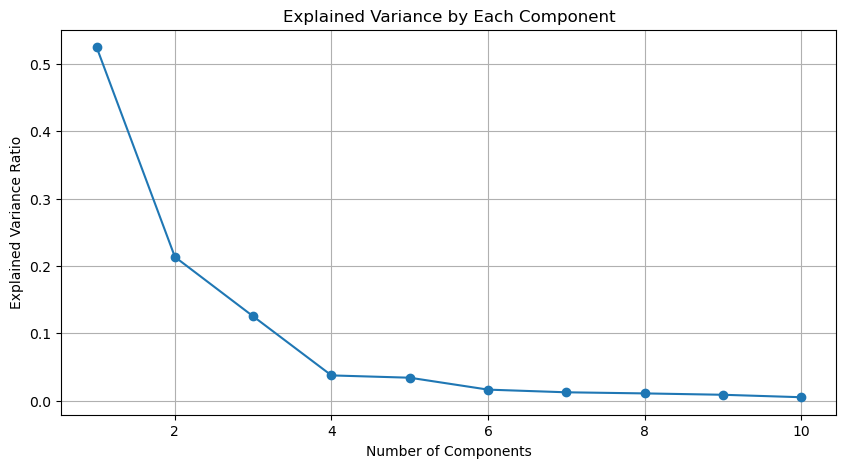

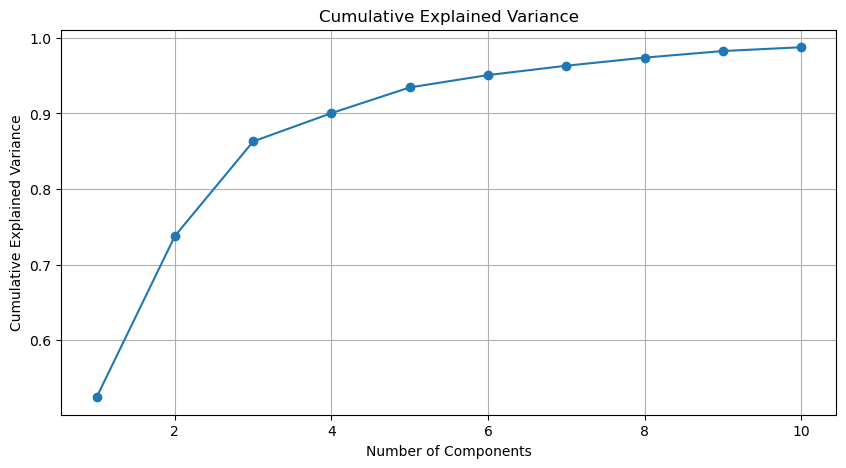

In [109]:
# Plot Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Each Component')
plt.grid(True)
plt.show()

# Plot Cumulative Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', label='Cumulative Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance')
plt.grid(True)
plt.show()


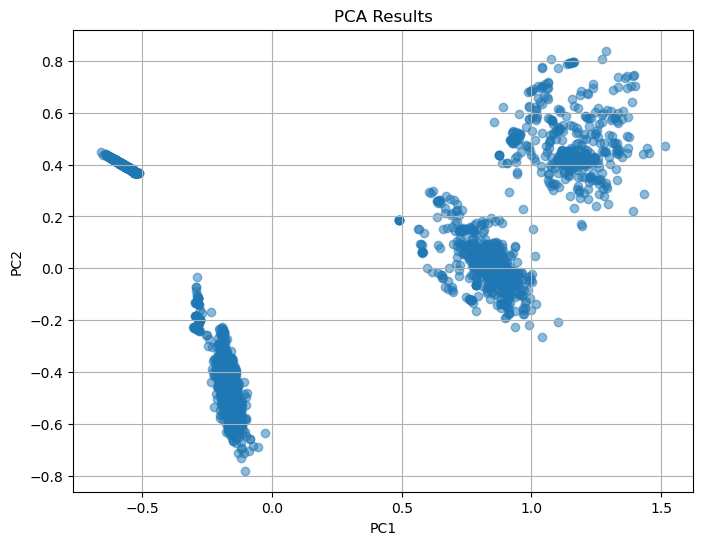

In [117]:
# Plot PCA results (2D)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title("PCA Results")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

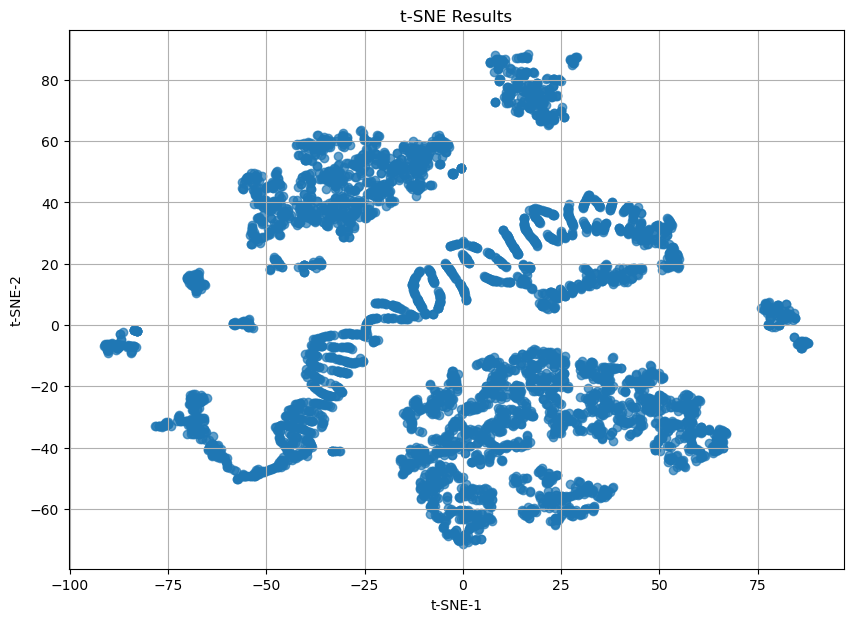

In [111]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X)

# Plot t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
plt.title("t-SNE Results")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(True)
plt.show()


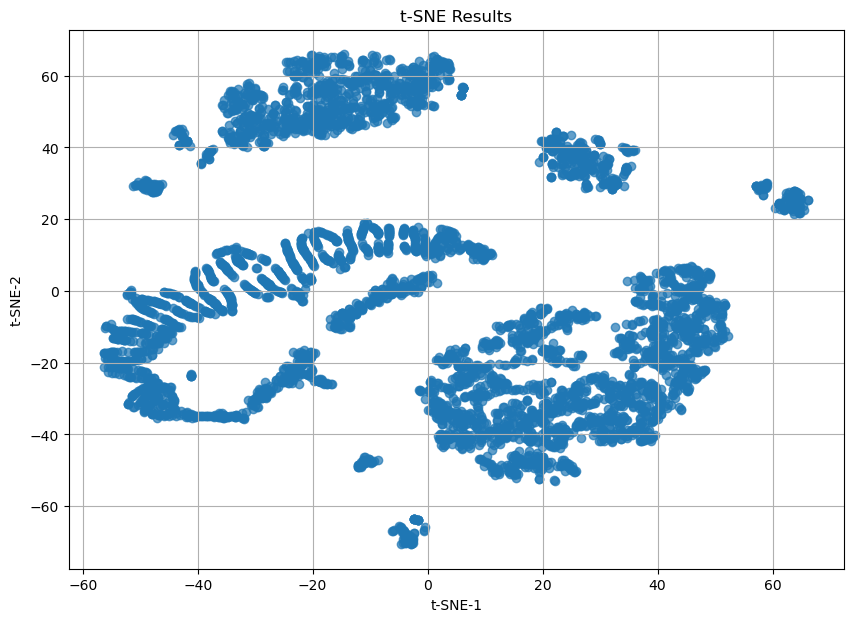

In [112]:
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=50)
X_tsne = tsne.fit_transform(X)

# Plot t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
plt.title("t-SNE Results")
plt.xlabel("t-SNE-1")
plt.ylabel("t-SNE-2")
plt.grid(True)
plt.show()

# Clustering

### KMeans - Pitstop data

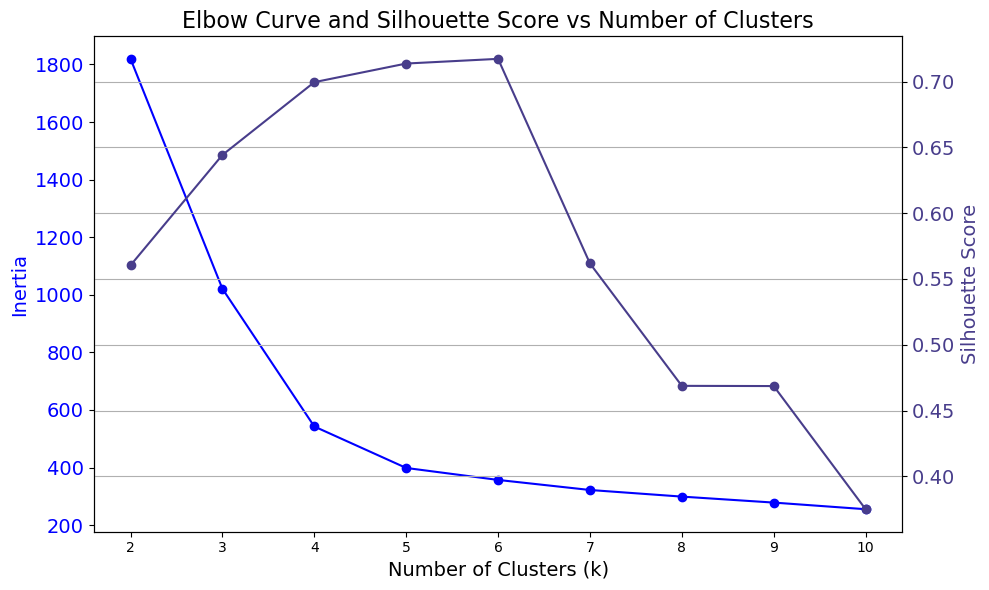

In [134]:
def kmeans_elbow_silhouette(X, cluster_range):

    inertia_scores = []
    silhouette_scores = []

    for k in cluster_range:
        # Initialize and fit KMeans
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=5000)
        labels = kmeans.fit_predict(X)

        # Calculate inertia
        inertia_scores.append(kmeans.inertia_)

        # Calculate silhouette score if there are more than 1 cluster
        if len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(X, labels))
        else:
            silhouette_scores.append(-1)  # Assign a low score for invalid clusters

    # Plot Elbow Curve and Silhouette Score
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Elbow Curve
    ax1.plot(cluster_range, inertia_scores, 'blue', marker='o', label='Inertia')
    ax1.set_xlabel("Number of Clusters (k)", fontsize=14)
    ax1.set_ylabel("Inertia", color="blue", fontsize=14)
    ax1.tick_params(axis="y", labelcolor="blue", labelsize=14)

    # Silhouette Score Curve
    ax2 = ax1.twinx()
    ax2.plot(cluster_range, silhouette_scores, 'darkslateblue', label='Silhouette Score', marker='o')
    ax2.set_ylabel("Silhouette Score", color='darkslateblue', fontsize=14)
    ax2.tick_params(axis="y", labelcolor='darkslateblue', labelsize=14)

    # Title and grid
    plt.title("Elbow Curve and Silhouette Score vs Number of Clusters", fontsize=16)
    plt.grid(True)
    fig.tight_layout()
    plt.show()


cluster_range = range(2, 11)  
kmeans_elbow_silhouette(X, cluster_range)


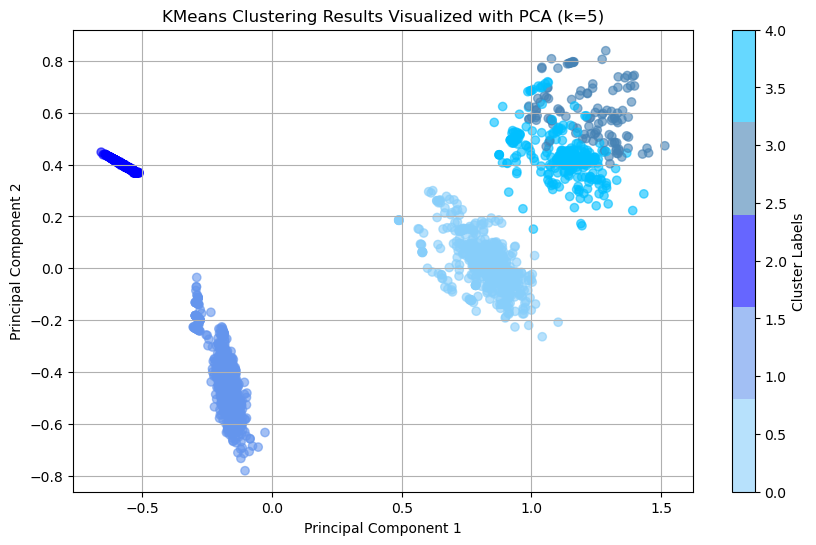

Silhouette Score for KMeans on PCA-transformed Data: 0.722


In [147]:
# Apply KMeans clustering with optimal K
kmeans = KMeans(n_clusters=5, n_init=10, random_state=5000)
kmeans_labels = kmeans.fit_predict(X_pca)

# Visualize clustering results on PCA-transformed data
custom_colors = ["lightskyblue", "cornflowerblue", "blue", "steelblue", "deepskyblue"]
custom_cmap = ListedColormap(custom_colors)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, alpha=0.6, cmap=custom_cmap)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'KMeans Clustering Results Visualized with PCA (k=5)')
plt.colorbar(scatter, label="Cluster Labels")
plt.grid(True)
plt.show()

# Evaluate silhouette score
sil_score = silhouette_score(X_pca, kmeans_labels)
print(f"Silhouette Score for KMeans on PCA-transformed Data: {sil_score:.3f}")

### DBSCAN - Pitstop data

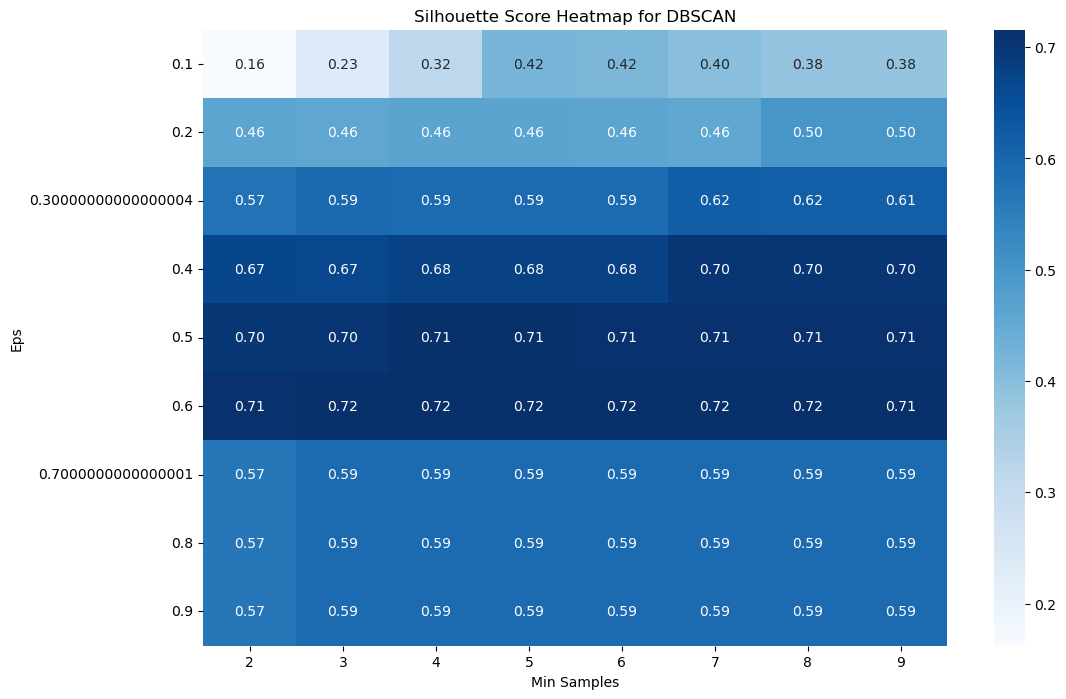

Best Silhouette Score: 0.7156373392601885
Optimal eps: 0.6
Optimal min_samples: 3


In [125]:
def optimize_dbscan_with_heatmap(X, eps_range, min_samples_range):
    best_score = -1
    best_eps = None
    best_min_samples = None
    best_labels = None
    best_cluster_count = None

    # Create a dictionary to store silhouette scores for heatmap
    score_dict = {}

    for eps in eps_range:
        score_dict[eps] = []
        for min_samples in min_samples_range:
            # Initialize DBSCAN
            model = DBSCAN(eps=eps, min_samples=min_samples)
            labels = model.fit_predict(X)

            # Calculate silhouette score if there are more than 1 cluster
            if len(set(labels)) > 1: 
                score = silhouette_score(X, labels)
            else:
                score = -1  

            score_dict[eps].append(score)

            if score > best_score:
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_labels = labels
                # Count clusters excluding noise
                best_cluster_count = len(set(labels)) - (1 if -1 in labels else 0)

    # Convert the score dictionary to a DataFrame for heatmap
    score_df = pd.DataFrame(score_dict, index=min_samples_range).T

    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(score_df, annot=True, fmt=".2f", cmap="Blues", xticklabels=min_samples_range, yticklabels=eps_range)
    plt.title("Silhouette Score Heatmap for DBSCAN")
    plt.xlabel("Min Samples")
    plt.ylabel("Eps")
    plt.show()

    # Output the optimal parameters
    print(f"Best Silhouette Score: {best_score}")
    print(f"Optimal eps: {best_eps}")
    print(f"Optimal min_samples: {best_min_samples}")

    return best_eps, best_min_samples, best_cluster_count, best_labels

eps_range = np.arange(0.1, 1.0, 0.1) 
min_samples_range = range(2, 10)  

best_eps, best_min_samples, best_cluster_count, best_labels = optimize_dbscan_with_heatmap(X, eps_range, min_samples_range)


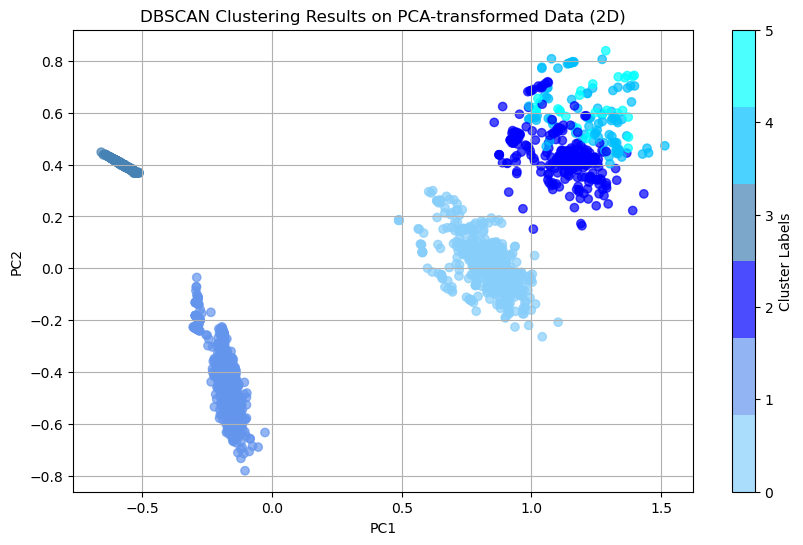

In [149]:
# Apply DBSCAN
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
dbscan_labels = dbscan.fit_predict(X_pca)

custom_colors = ["lightskyblue", "cornflowerblue", "blue", "steelblue", "deepskyblue", "cyan"]
custom_cmap = ListedColormap(custom_colors)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap=custom_cmap, alpha=0.7)
plt.title("DBSCAN Clustering Results on PCA-transformed Data (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(scatter, label="Cluster Labels")
plt.grid(True)
plt.show()


In [131]:
num_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
print(f"Number of clusters found: {num_clusters}")


Number of clusters found: 6


## Hierarchical Clustering

In [150]:
# load the data
df = pd.read_csv("../../data/processed-data/race_track_features.csv")
df.head()

,Year,Grand Prix,Track Length (m),Max Speed (km/h),Full Throttle (%),Number of Corners,Number of Straights,Unnamed: 7
0,2020,Pre-Season Test 1,-1.000607,-0.115670,1.059667,-0.789651,-0.938394,NaN
1,2020,Pre-Season Test 2,-1.000607,-0.115670,1.059667,-0.789651,-0.938394,NaN
2,2020,Austrian Grand Prix,-1.000607,-0.115670,1.059667,-0.789651,-0.938394,NaN
3,2020,Styrian Grand Prix,-1.024865,-1.840980,-1.757479,-0.275003,-0.037811,NaN
4,2020,Hungarian Grand Prix,-0.957039,-0.490737,-0.407433,-1.304300,-0.037811,NaN


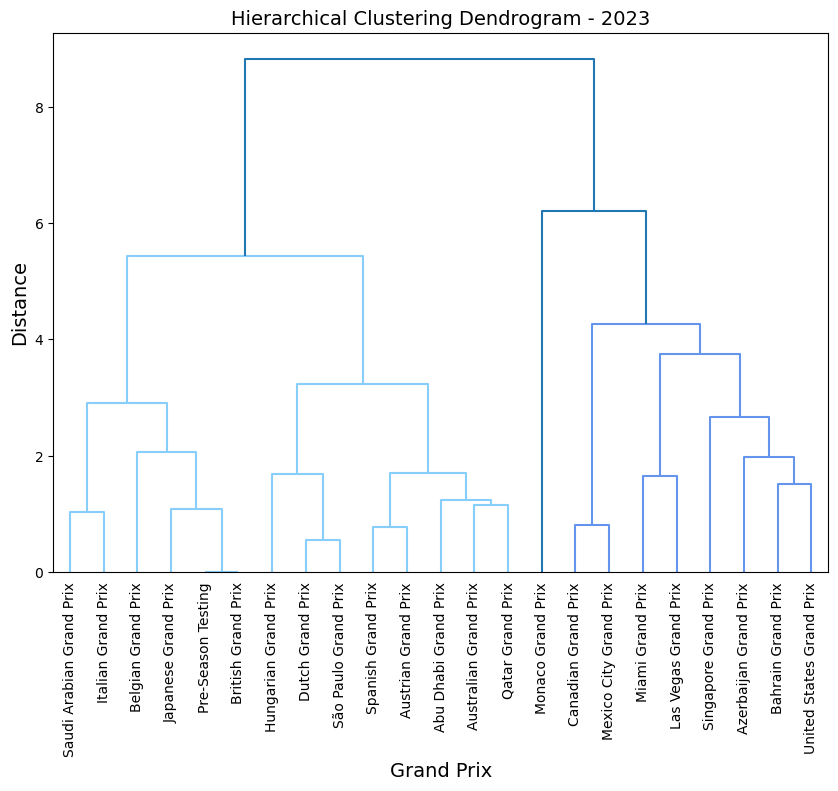

In [151]:
set_link_color_palette(["lightskyblue", "cornflowerblue", "blue", "steelblue"])

df = pd.read_csv("../../data/processed-data/race_track_features.csv")
df = df[df["Year"] == 2023]

features = ["Track Length (m)", "Max Speed (km/h)", "Full Throttle (%)", "Number of Corners", "Number of Straights"]
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

linkage_matrix = linkage(X_scaled, method='ward')  

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=df["Grand Prix"].values, leaf_rotation=90, leaf_font_size=10,color_threshold=6)
plt.title("Hierarchical Clustering Dendrogram - 2023", fontsize = 14)

plt.xlabel("Grand Prix", fontsize = 14)
plt.ylabel("Distance", fontsize = 14)
plt.show()

max_distance = 6
clusters = fcluster(linkage_matrix, max_distance, criterion='distance')

